分類（アンダーサンプリング）→回帰

## 必要なライブラリのimport

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
# 予測したいデータの読み込み
path_test_preprp = '../../../../data/processed/test_processed_20.csv'

test = pd.read_csv(path_test_preprp)
#del test['target']

## 保存されたモデルを使って予測を行う

In [3]:
n_folds = 5
predictions_cls = np.zeros(len(test))
features = [c for c in test.columns if c not in ['card_id',]]


for fold_ in range(n_folds):
    # モデルを読み込む
    with open(f'../src/models/lgb_22_cls/model_fold_{fold_}.pkl', 'rb') as f:
        clf = pickle.load(f)
    # モデルで予測を行う
    fold_predictions = clf.predict(test[features])
    # 予測結果を足し合わせる
    predictions_cls += fold_predictions

# 平均を取る
predictions_cls /= n_folds

# RMSEを計算する（テストデータに対して真の値がある場合）
# y_testが存在する場合に限り
if 'y_test' in locals():
    score = mean_squared_error(y_test, predictions_cls, squared=False)
    print(f'RMSE={score}')


In [5]:
print(len(predictions_cls[predictions_cls<0.1]))
print(predictions_cls.min())

# 予測結果を出力する
print(predictions_cls)

1735
0.03808279970611227
[0.2523123  0.91356534 0.57227297 ... 0.61426449 0.07022103 0.68573278]


In [6]:
predictions_cls_done = np.where(predictions_cls < 0.1, -33.21928095, 1)

In [7]:
tmp_cls = pd.DataFrame({"card_id":test["card_id"].values})
tmp_cls["target"] = predictions_cls_done
tmp_cls

,card_id,target
0,C_ID_0ab67a22ab,1.000000
1,C_ID_130fd0cbdd,1.000000
2,C_ID_b709037bc5,1.000000
3,C_ID_d27d835a9f,1.000000
4,C_ID_2b5e3df5c2,1.000000
...,...,...
123618,C_ID_7a239d2eda,1.000000
123619,C_ID_75ace375ae,1.000000
123620,C_ID_21d56d950c,1.000000
123621,C_ID_6c46fc5a9d,-33.219281


In [8]:
test_reg = test[test.card_id.isin(tmp_cls[tmp_cls.target==1].card_id)].reset_index(drop=True)

In [9]:
test_reg

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_frequency,hist_amount_total,hist_amount_mean,hist_amount_max,...,total_month_lag_max,total_month_lag_min,total_month_lag_median,total_category_1_mod,total_category_2_mod,total_category_3_mod,total_duration,ratio_amount_total,ratio_amount_mean,ratio_merchant_category_nu
0,1978,C_ID_0ab67a22ab,3,3,1,306,68,-40.733734,-0.599025,0.235676,...,2,-8,-3.0,0,1.0,2.0,330,0.043633,0.989020,0.187500
1,1888,C_ID_130fd0cbdd,2,3,0,396,78,-49.136513,-0.629955,0.318817,...,2,-13,-10.0,0,4.0,2.0,462,0.120976,1.048458,0.500000
2,2100,C_ID_b709037bc5,5,1,1,184,13,4.528841,0.348372,2.525866,...,1,-6,-2.0,0,5.0,3.0,199,0.039676,0.257896,0.250000
3,2222,C_ID_d27d835a9f,2,1,0,62,26,-13.690715,-0.526566,0.087965,...,2,-2,0.0,0,1.0,2.0,134,0.419583,1.090915,0.555556
4,1491,C_ID_2b5e3df5c2,5,1,1,793,110,25.139385,0.228540,15.782255,...,2,-13,-6.0,0,4.0,2.0,464,0.479980,8.799636,0.161290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121883,1796,C_ID_0e74bd4966,3,2,1,488,125,-86.713540,-0.693708,-0.088206,...,2,-10,-5.0,0,3.0,1.0,363,0.016234,1.014630,0.105263
121884,2161,C_ID_7a239d2eda,2,2,0,123,73,-49.404780,-0.676778,-0.525387,...,0,-4,-2.0,0,1.0,1.0,134,NaN,NaN,NaN
121885,2131,C_ID_75ace375ae,3,1,1,153,7,-4.914616,-0.702088,-0.578911,...,2,-5,-2.0,0,1.0,1.0,206,0.540877,0.946535,1.000000
121886,1766,C_ID_21d56d950c,5,1,1,518,37,-6.583716,-0.177938,1.664306,...,0,-10,-5.0,0,5.0,2.0,305,NaN,NaN,NaN


In [10]:
n_folds = 5
predictions = np.zeros(len(test_reg))
features = [c for c in test_reg.columns if c not in ['card_id',]]
#categorical_feats = ['feature_1','feature_2', 'feature_3','hist_merchant_category_nu','hist_merchant_category_mode','hist_city_nu','hist_city_mode','hist_state_nu','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod','new_merchant_category_nu','new_merchant_category_mode','new_city_nu','new_city_mode','new_state_nu','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']


for fold_ in range(n_folds):
    # モデルを読み込む
    with open(f'../src/models/lgb_21_reg/model_fold_{fold_}.pkl', 'rb') as f:
        clf = pickle.load(f)
    # モデルで予測を行う
    fold_predictions = clf.predict(test_reg[features])
    # 予測結果を足し合わせる
    predictions += fold_predictions

# 平均を取る
predictions /= n_folds

# RMSEを計算する（テストデータに対して真の値がある場合）
# y_testが存在する場合に限り
if 'y_test' in locals():
    score = mean_squared_error(y_test, predictions, squared=False)
    print(f'RMSE={score}')

In [88]:
# 予測結果を出力する
print(predictions)

[-0.10077957  0.02924514  0.63447003 ...  0.94123341 -0.6613987
  0.26516787]


In [11]:
tmp_reg = pd.DataFrame({"card_id":test_reg["card_id"].values})
tmp_reg["target"] = predictions
tmp_reg
sub = pd.merge(tmp_cls,tmp_reg,how='left',on='card_id',suffixes=('_left', '_right'))
sub['target'] = sub['target_right'].combine_first(sub['target_left'])

# 不要な列を削除
sub= sub.drop(columns=['target_left', 'target_right'])
sub[sub.target  >0]

,card_id,target
5,C_ID_5814b4f13c,0.419815
6,C_ID_a1b3c75277,0.229288
7,C_ID_f7cada36d3,0.949763
11,C_ID_0e281e8ad6,0.041345
12,C_ID_8375dfdaa2,0.028700
...,...,...
123616,C_ID_107d93e20c,1.331442
123617,C_ID_0e74bd4966,0.480041
123618,C_ID_7a239d2eda,0.973505
123620,C_ID_21d56d950c,1.001798


In [12]:
sub

,card_id,target
0,C_ID_0ab67a22ab,-0.157102
1,C_ID_130fd0cbdd,-0.223990
2,C_ID_b709037bc5,-0.407277
3,C_ID_d27d835a9f,-0.065234
4,C_ID_2b5e3df5c2,-0.924936
...,...,...
123618,C_ID_7a239d2eda,0.973505
123619,C_ID_75ace375ae,-0.208551
123620,C_ID_21d56d950c,1.001798
123621,C_ID_6c46fc5a9d,-33.219281


(array([1.7350e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

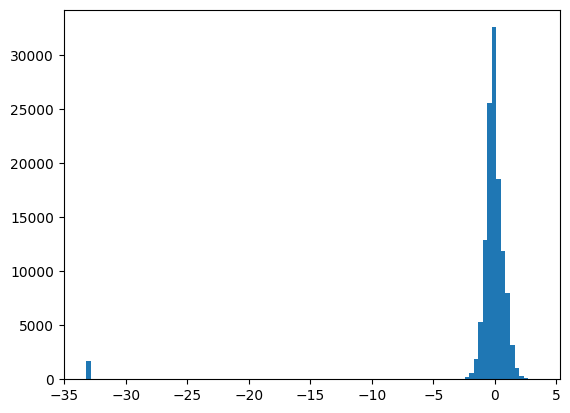

In [13]:
import matplotlib.pyplot as plt
plt.hist(sub.target,bins=100)

## 提出用ファイルの作成

In [14]:
sub.to_csv("../submit_oshikiri_22.csv", index=False)